In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from chart_studio import plotly
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import seaborn as sns
import datetime, pytz
import torch
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from numpy import log
from statsmodels.tsa.stattools import acf
import random
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.api import  SimpleExpSmoothing

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('btc.txt',sep=',',
                         index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [4]:
stock_data

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.650000,1003.080000,958.690000,998.325000,147775008
2017-01-02,998.617000,1031.390000,996.702000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2023-04-16,30315.976420,30555.537630,30157.832330,30315.355460,12854816417
2023-04-17,30317.145700,30319.196580,29275.371060,29445.044900,17872186762
2023-04-18,29449.091700,30470.302010,29154.849370,30397.552740,19480529496


In [5]:
stock_data = stock_data.drop('High', axis=1)
stock_data = stock_data.drop('Low', axis=1)
stock_data = stock_data.drop('Close', axis=1)
stock_data = stock_data.drop('Volume', axis=1)
stock_data = stock_data.rename(columns={'Open': 'Price'})
stock_data

,Price
Date,
2017-01-01,963.650000
2017-01-02,998.617000
2017-01-03,1021.599976
2017-01-04,1044.400024
2017-01-05,1156.729980
...,...
2023-04-16,30315.976420
2023-04-17,30317.145700
2023-04-18,29449.091700


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2301 entries, 2017-01-01 to 2023-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2301 non-null   float64
dtypes: float64(1)
memory usage: 36.0 KB


In [7]:
stock_data.isnull().sum()

Price    0
dtype: int64

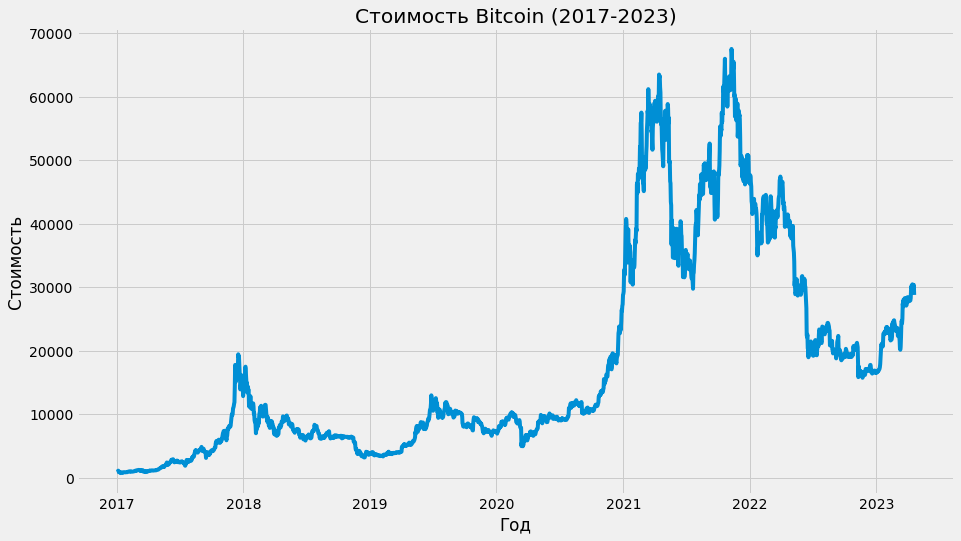

In [8]:
plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(stock_data)
plt.title('Стоимость Bitcoin (2017-2023)')
plt.show()

# Анализ

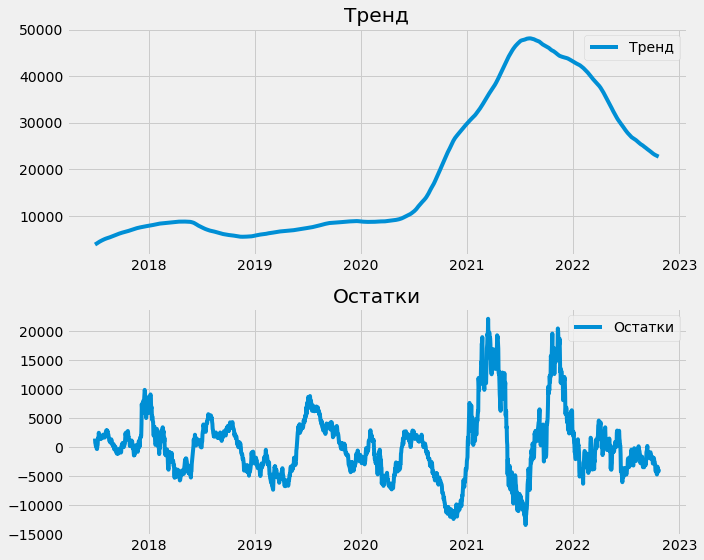

In [9]:
result = seasonal_decompose(stock_data['Price'], model='additive', freq = 360)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(result.trend, label='Тренд')
plt.legend(loc='best')
plt.title('Тренд')

plt.subplot(2, 1, 2)
plt.plot(result.resid, label='Остатки')
plt.legend(loc='best')
plt.title('Остатки')
plt.tight_layout()
plt.show()

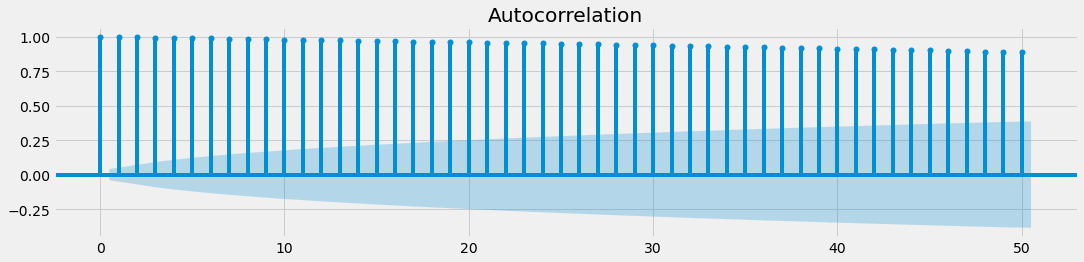

In [9]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(stock_data.squeeze(), lags=50, ax=ax)
plt.tight_layout()
plt.show()

#### Тест стационарности и преобразование

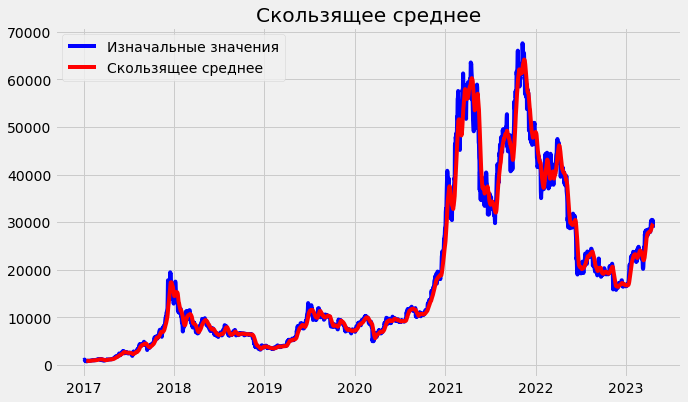

In [10]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.plot(timeseries, color='blue',label='Изначальные значения')
    plt.plot(rolmean, color='red', label='Скользящее среднее')
    plt.legend(loc='best')
    plt.title('Скользящее среднее')
    plt.show(block=False)
    
test_stationarity(stock_data)

In [11]:
def adf_test(timeseries):
    print("Результаты теста ADF:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Статистический критерий",
            "p-value",
            "Число лагов",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Критическое значение (%s)" % key] = value
    print(dfoutput)
    
adf_test(stock_data)

Результаты теста ADF:
Статистический критерий       -1.655783
p-value                        0.454026
Число лагов                   27.000000
Критическое значение (1%)     -3.433230
Критическое значение (5%)     -2.862812
Критическое значение (10%)    -2.567447
dtype: float64


In [12]:
def kpss_test(timeseries):
    print("Результаты теста KPSS:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Статистический критерий", "p-value", "Число лагов"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Критическое значение (%s)" % key] = value
    print(kpss_output)
    
kpss_test(stock_data)

Результаты теста KPSS:
Статистический критерий         4.357005
p-value                         0.010000
Число лагов                    29.000000
Критическое значение (10%)      0.347000
Критическое значение (5%)       0.463000
Критическое значение (2.5%)     0.574000
Критическое значение (1%)       0.739000
dtype: float64


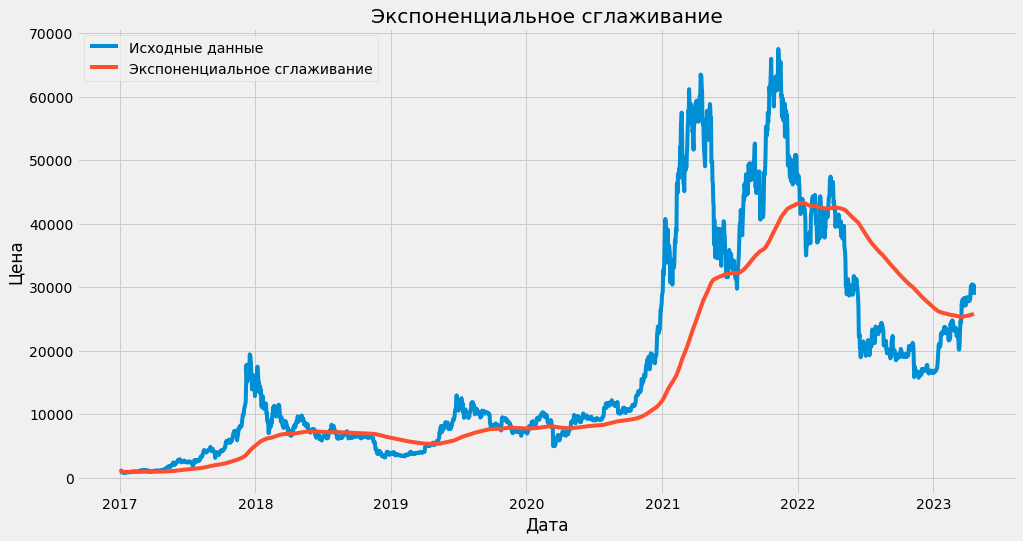

In [12]:
alpha = 0.005  
exponential_smoothed = stock_data['Price'].ewm(alpha=alpha, adjust=False).mean()

# Построение графика
plt.figure(figsize=(15, 8))
plt.plot(stock_data.index, stock_data['Price'], label='Исходные данные')
plt.plot(stock_data.index, exponential_smoothed, label='Экспоненциальное сглаживание')
plt.title('Экспоненциальное сглаживание')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Метрики оценивания

In [2]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

def metrics(forecast, test):
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mean_obs = test.mean()
    si = (rmse/mean_obs)*100
    mape = np.mean(np.abs((test - forecast) / test))*100
    
    return mae, rmse, si, mape

# Разделение выборки и построение ARIMA

In [90]:
stock_data['Price'] = exponential_smoothed

In [142]:
train_size = int(len(stock_data) * 0.85)
train_data = stock_data.iloc[:train_size]
test_data = stock_data.iloc[train_size:]

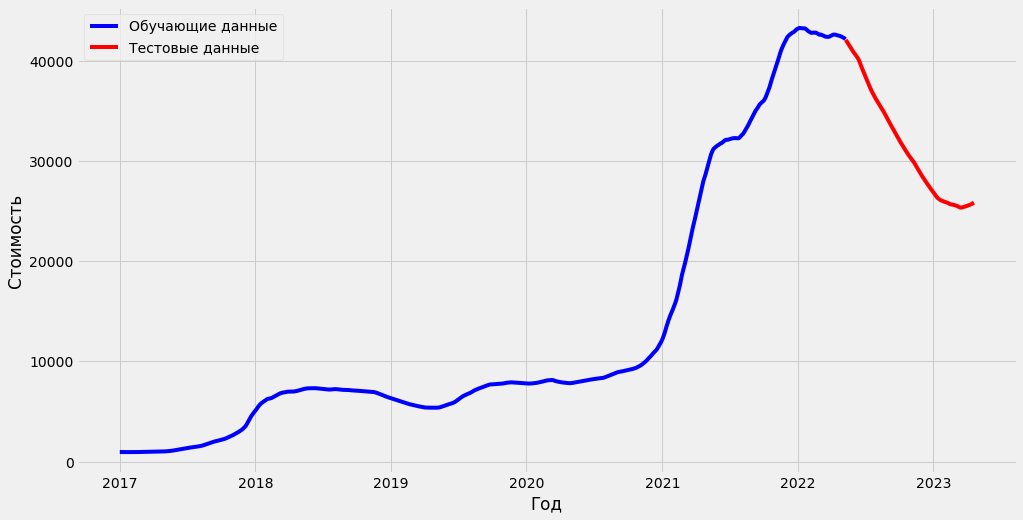

In [143]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(train_data, 'blue', label='Обучающие данные')
plt.plot(test_data, 'red', label='Тестовые данные')
plt.legend()

Подбор параметров при помощи auto_arima

In [144]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11662.421, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11661.870, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11661.829, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11660.458, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11663.788, Time=0.38 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.603 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1955
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -5829.229
Date:                Sat, 20 May 2023   AIC                          11660.458
Time:                        15:16:23   BIC                          11666.035
Sample:                             0   HQIC                         11662.508
                               - 1955                                  

In [145]:
model = ARIMA(train_data, order=(0,2,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Price   No. Observations:                 1953
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -5829.210
Method:                           css   S.D. of innovations              4.787
Date:                Sat, 20 May 2023   AIC                          11662.421
Time:                        15:16:23   BIC                          11673.575
Sample:                    01-03-2017   HQIC                         11666.521
                         - 05-09-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.108     -0.193      0.847      -0.233       0.191


In [146]:
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)

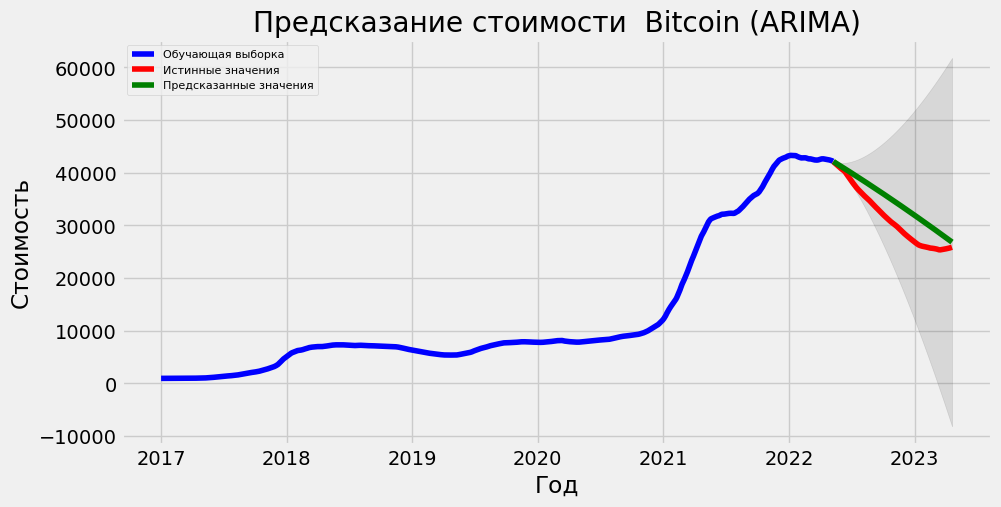

In [147]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, color = 'blue',label='Обучающая выборка')
plt.plot(test_data, color = 'red', label='Истинные значения')
plt.plot(fc_series, color = 'green',label='Предсказанные значения')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Предсказание стоимости  Bitcoin (ARIMA)')
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [148]:
fc_reshape =fc.reshape(len(test_data),1)

In [149]:
mae, rmse, si, mape = metrics(fc,test_data['Price'])

print("MAE:", mae)
print("RMSE:", rmse)
print('SI:' + toFixed(si, 2) + "%")
print('MAPE:' + toFixed(mape, 2) + "%")

MAE: 3198.5657443416403
RMSE: 3537.804888931613
SI:11.24%
MAPE:10.96%


In [150]:
test_data['Price']

Date
2022-05-10    42093.325839
2022-05-11    42037.940124
2022-05-12    41972.434093
2022-05-13    41907.726474
2022-05-14    41844.616057
                  ...     
2023-04-16    25774.902784
2023-04-17    25797.613998
2023-04-18    25815.871387
2023-04-19    25838.762969
2023-04-20    25853.687569
Name: Price, Length: 346, dtype: float64

# SARIMA

In [171]:
train_sizeSARIMA = int(len(stock_data) * 0.85)
train_dataSARIMA = stock_data.iloc[:train_sizeSARIMA]
test_dataSARIMA = stock_data.iloc[train_sizeSARIMA:]

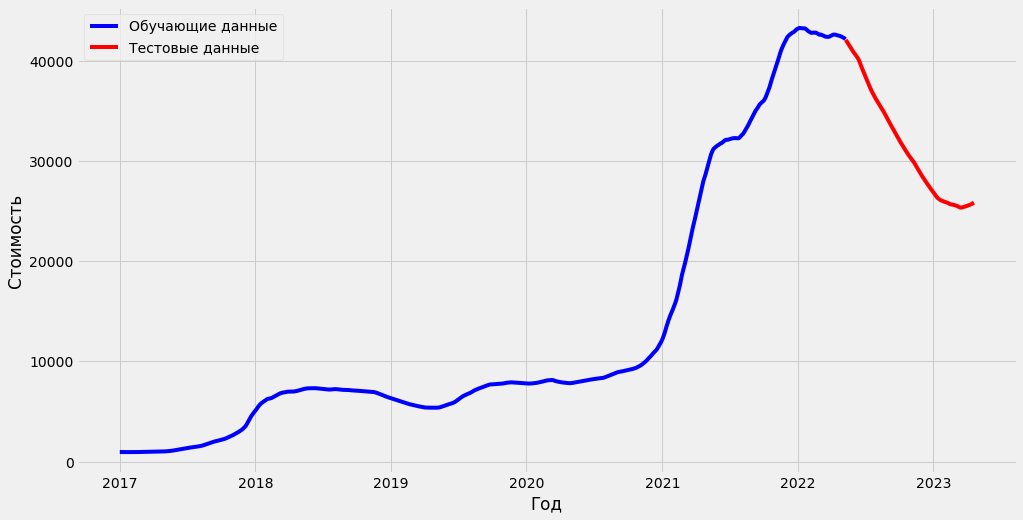

In [172]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(train_dataSARIMA, 'blue', label='Обучающие данные')
plt.plot(test_dataSARIMA, 'red', label='Тестовые данные')
plt.legend()

In [182]:
smodel = pm.auto_arima(train_dataSARIMA, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16421.607, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12292.758, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=14730.462, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12982.225, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12140.298, Time=1.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16406.834, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12141.913, Time=1.60 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=12141.916, Time=1.29 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=14704.406, Time=1.02 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=12143.790, Time=1.42 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=12142.264, Time=3.68 sec

Best model:  ARIMA(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1955
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6066.149
Date:                            Sat, 20 May 2023   AIC                          12140.298
Time:                                    16:50:17   BIC                          12162.584
Sample:                                         0   HQIC                         12148.494
                                           - 1955                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9650      0.003    310.576      0.000       0.959       0.971
ar.S.L12      -0.7130      0.012    -61.433      0.000      -0.736      -0.690
ar.S.L24      -0.2792      0.012    -22.956      0.000      -0.303      -0.255
sigma2        30.1211      0.389     77.453      0.000      29.359      30.883
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):              9203.67
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):              13.63   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [178]:
model = SARIMAX(train_dataSARIMA, order=(1,1,0), seasonal_order=(2,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                 1955
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6066.149
Date:                            Sat, 20 May 2023   AIC                          12140.298
Time:                                    15:56:00   BIC                          12162.584
Sample:                                01-01-2017   HQIC                         12148.494
                                     - 05-09-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9650      0.003    310.576      0.000       0.959       0.971
ar.S.L12      -0.7130      0.012   

In [179]:
start_index = len(train_dataSARIMA)
end_index = len(train_dataSARIMA) + len(test_dataSARIMA) - 1
forecast = model_fit.predict(start=start_index, end=end_index)

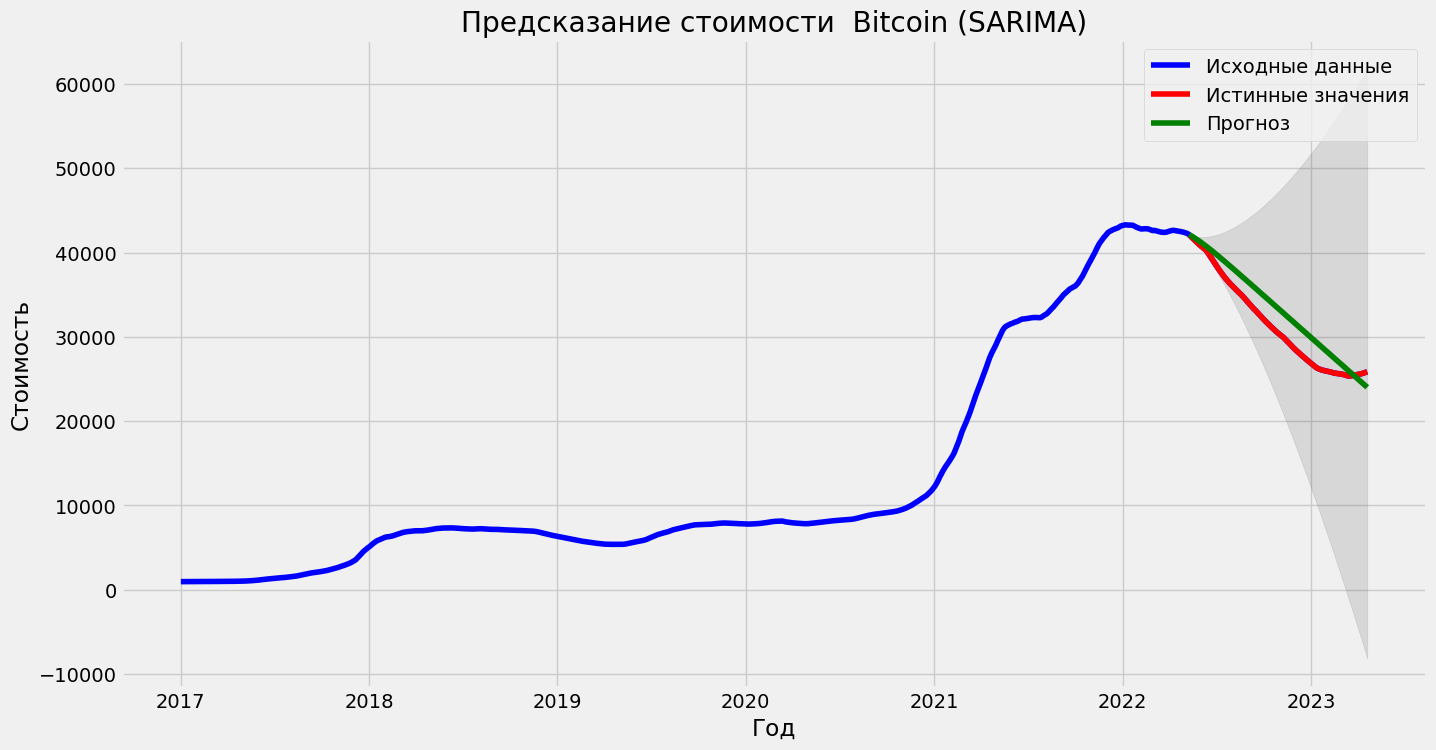

In [180]:
plt.figure(figsize=(15,8), dpi=100)
plt.plot(stock_data.index, stock_data['Price'], color = 'blue', label='Исходные данные')
plt.plot(test_dataSARIMA, color = 'red', label='Истинные значения')
plt.plot(test_dataSARIMA.index, forecast, color = 'green', label='Прогноз')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Предсказание стоимости  Bitcoin (SARIMA)')
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.legend()
plt.show()

In [181]:
mae, rmse, si, mape = metrics(forecast,test_data['Price'])

print("MAE:", mae)
print("RMSE:", rmse)
print('SI:' + toFixed(si, 2) + "%")
print('MAPE:' + toFixed(mape, 2) + "%")

MAE: 1975.2778824001057
RMSE: 2210.1885538353467
SI:7.02%
MAPE:6.57%


# Построение LSTM

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Истинные значения')
    plt.plot(predicted, color='green',label='Предсказанные значения')
    plt.title('Предсказание стоимости Bitcoin')
    plt.xlabel('Измерение')
    plt.ylabel('Стоимость')
    plt.legend()
    plt.show()

In [17]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('btc.txt',sep=',',
                         index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data = stock_data.rename(columns={'Open': 'Price'})
stock_data

,Price,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.650000,1003.080000,958.690000,998.325000,147775008
2017-01-02,998.617000,1031.390000,996.702000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2023-04-16,30315.976420,30555.537630,30157.832330,30315.355460,12854816417
2023-04-17,30317.145700,30319.196580,29275.371060,29445.044900,17872186762
2023-04-18,29449.091700,30470.302010,29154.849370,30397.552740,19480529496


In [18]:
train_size = int(len(stock_data) * 0.85)
train_data_plot, test_data_plot = stock_data[:train_size+1], stock_data[train_size:]

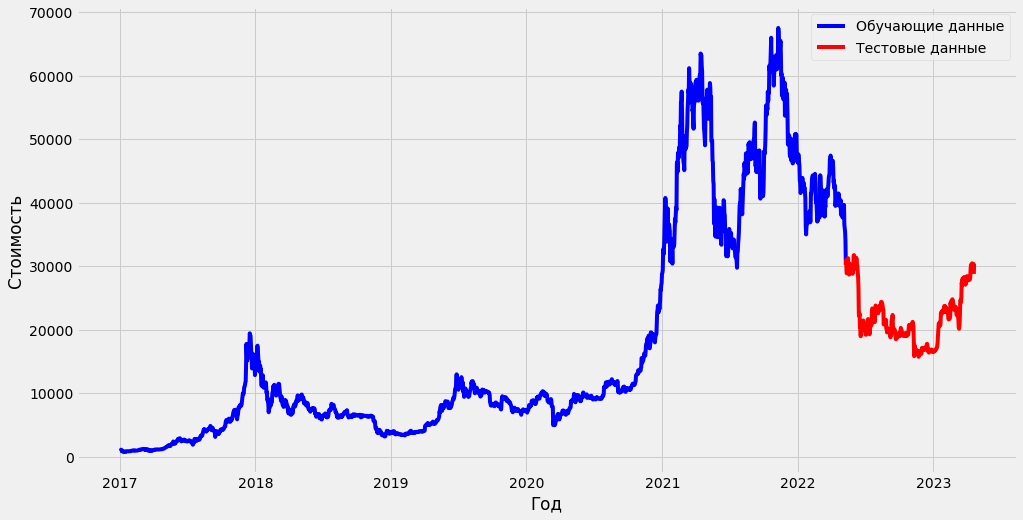

In [19]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(train_data_plot['Price'], 'blue', label='Обучающие данные')
plt.plot(test_data_plot['Price'], 'red', label='Тестовые данные')
plt.legend()

In [20]:
prices = stock_data['Price'].values.reshape(-1, 1)

In [21]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

In [22]:
train_size = int(len(scaled_prices) * 0.85)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:]

In [23]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

In [24]:
lookback = 60 
train_X, train_y = create_dataset(train_data, lookback)
test_X, test_y = create_dataset(test_data, lookback)

In [31]:
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/100
15/15 [==============================] - 1s 29ms/step - loss: 0.0305 - val_loss: 0.0083
Epoch 2/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 5.0784e-04
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 4.4148e-04
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 4.7107e-04
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 3.4523e-04
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 3.3373e-04
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 3.0894e-04
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 3.9990e-04
Epoch 10/100
15/15 [==============================] - 0s 16ms/step - los

15/15 [==============================] - 0s 15ms/step - loss: 9.5462e-04 - val_loss: 1.9006e-04
Epoch 79/100
15/15 [==============================] - 0s 16ms/step - loss: 8.5395e-04 - val_loss: 1.9096e-04
Epoch 80/100
15/15 [==============================] - 0s 15ms/step - loss: 8.5595e-04 - val_loss: 1.8294e-04
Epoch 81/100
15/15 [==============================] - 0s 15ms/step - loss: 8.1851e-04 - val_loss: 1.8197e-04
Epoch 82/100
15/15 [==============================] - 0s 15ms/step - loss: 9.3302e-04 - val_loss: 2.1662e-04
Epoch 83/100
15/15 [==============================] - 0s 15ms/step - loss: 8.8242e-04 - val_loss: 2.2875e-04
Epoch 84/100
15/15 [==============================] - 0s 15ms/step - loss: 9.9338e-04 - val_loss: 1.9408e-04
Epoch 85/100
15/15 [==============================] - 0s 16ms/step - loss: 9.1248e-04 - val_loss: 1.8030e-04
Epoch 86/100
15/15 [==============================] - 0s 16ms/step - loss: 8.9705e-04 - val_loss: 2.2271e-04
Epoch 87/100
15/15 [============

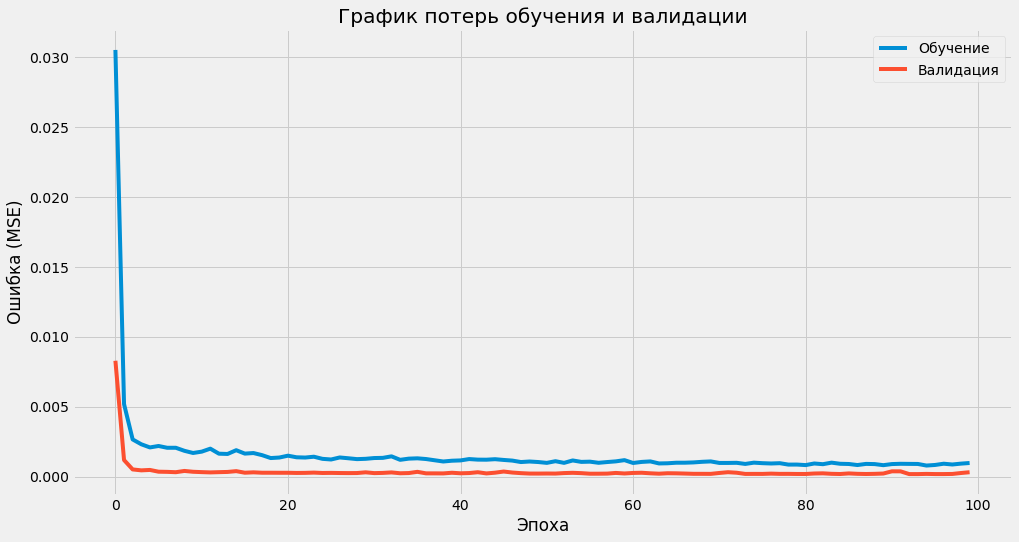

In [32]:
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.title('График потерь обучения и валидации')
plt.legend()
plt.show()

In [33]:
test_predict = model.predict(test_X)

In [34]:
test_predict = scaler.inverse_transform(test_predict)
test = scaler.inverse_transform(test_y)

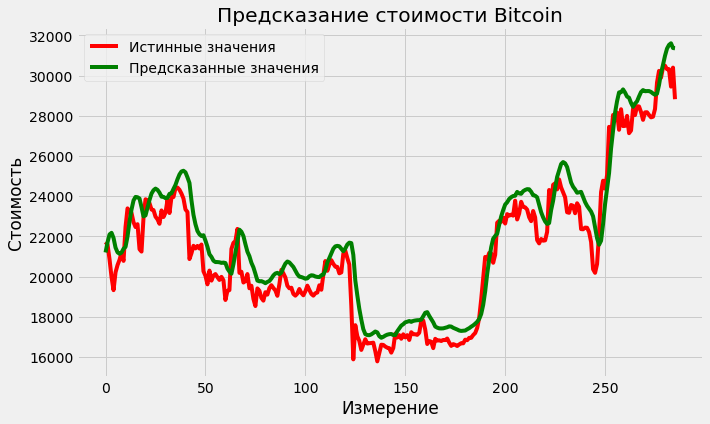

In [35]:
plot_predictions(test,test_predict)

In [36]:
mae, rmse, si, mape = metrics(test_predict,test)

print("MAE:", mae)
print("RMSE:", rmse)
print('SI:' + toFixed(si, 2) + "%")
print('MAPE:' + toFixed(mape, 2) + "%")

MAE: 969.3799245826057
RMSE: 1171.2938725646452
SI:5.50%
MAPE:4.65%


# GRU

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('btc.txt',sep=',',
                         index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data = stock_data.rename(columns={'Open': 'Price'})
stock_data

,Price,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.650000,1003.080000,958.690000,998.325000,147775008
2017-01-02,998.617000,1031.390000,996.702000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2023-04-16,30315.976420,30555.537630,30157.832330,30315.355460,12854816417
2023-04-17,30317.145700,30319.196580,29275.371060,29445.044900,17872186762
2023-04-18,29449.091700,30470.302010,29154.849370,30397.552740,19480529496


In [5]:
prices = stock_data['Price'].values.reshape(-1, 1)

In [6]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

In [7]:
train_size = int(len(scaled_prices) * 0.85)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:]

In [10]:
lookback = 60  
train_X, train_y = create_dataset(train_data, lookback)
test_X, test_y = create_dataset(test_data, lookback)

In [11]:
model = Sequential()
model.add(GRU(50, activation='tanh', input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/100
15/15 [==============================] - 1s 32ms/step - loss: 0.0712 - val_loss: 0.0014
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0196 - val_loss: 9.1313e-04
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 3.2531e-04
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 5.3954e-04
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 2.1841e-04
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 2.7453e-04
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 2.1040e-04
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 2.1473e-04
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 2.9170e-04
Epoch 10/100
15/15 [==============================] - 0s 14ms/step -

Epoch 78/100
15/15 [==============================] - 0s 14ms/step - loss: 8.1751e-04 - val_loss: 2.0466e-04
Epoch 79/100
15/15 [==============================] - 0s 14ms/step - loss: 9.3130e-04 - val_loss: 1.2077e-04
Epoch 80/100
15/15 [==============================] - 0s 14ms/step - loss: 7.7803e-04 - val_loss: 1.2500e-04
Epoch 81/100
15/15 [==============================] - 0s 14ms/step - loss: 7.8627e-04 - val_loss: 1.2733e-04
Epoch 82/100
15/15 [==============================] - 0s 14ms/step - loss: 7.9949e-04 - val_loss: 1.2158e-04
Epoch 83/100
15/15 [==============================] - 0s 13ms/step - loss: 8.2786e-04 - val_loss: 1.1933e-04
Epoch 84/100
15/15 [==============================] - 0s 14ms/step - loss: 8.4512e-04 - val_loss: 1.3565e-04
Epoch 85/100
15/15 [==============================] - 0s 13ms/step - loss: 8.6812e-04 - val_loss: 1.9668e-04
Epoch 86/100
15/15 [==============================] - 0s 14ms/step - loss: 8.0688e-04 - val_loss: 1.2181e-04
Epoch 87/100
15/15 

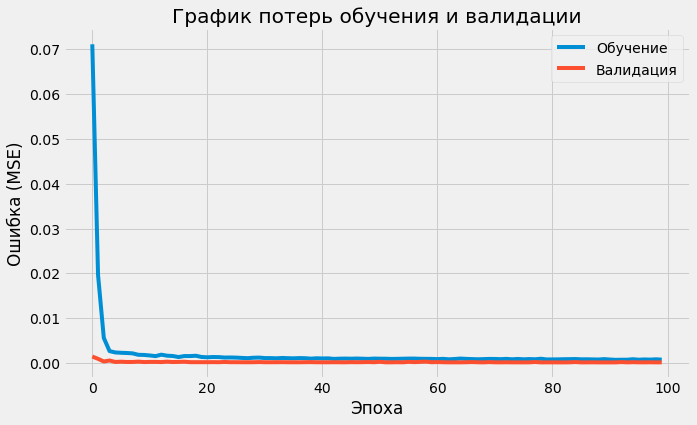

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.title('График потерь обучения и валидации')
plt.legend()
plt.show()

In [13]:
test_predict = model.predict(test_X)

In [14]:
test_predict = scaler.inverse_transform(test_predict)
test = scaler.inverse_transform(test_y)

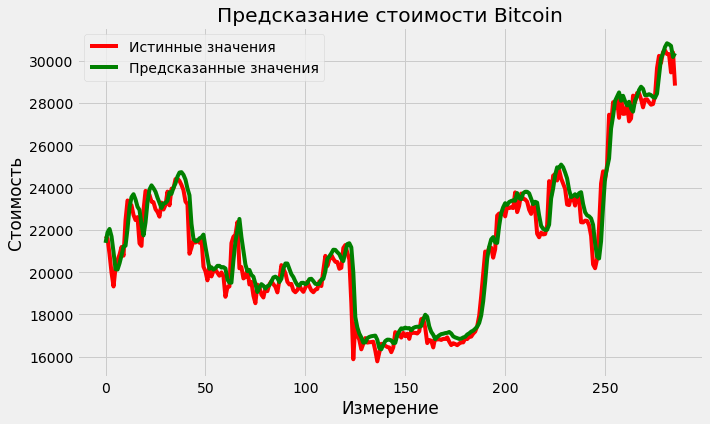

In [15]:
plot_predictions(test,test_predict)

In [16]:
mae, rmse, si, mape = metrics(test_predict,test)

print("MAE:", mae)
print("RMSE:", rmse)
print('SI:' + toFixed(si, 2) + "%")
print('MAPE:' + toFixed(mape, 2) + "%")

MAE: 540.6142580944064
RMSE: 760.4898215079571
SI:3.57%
MAPE:2.57%
